In [455]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from torch.distributions import Normal
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
from tqdm import tqdm
import cv2
from PIL import Image
import matplotlib.pyplot as plt
# from sklearn.metrics import r2_score
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# Data

In [596]:
df = pd.read_csv('match.csv')
df.head()

,Unnamed: 0,0,frame_id_forward,frame_id_left,latitude,longtitude,speed,steer,time,angular_velocity
0,6,NaN,4666,3351,31.183185,121.600915,2.68224,6.010914,15613687382,0.0070
1,6,NaN,4668,3352,31.183185,121.600915,2.68224,6.010914,15613687384,0.0044
2,6,NaN,4670,3353,31.183185,121.600915,2.68224,6.010914,15613687386,0.0072
3,6,NaN,4671,3354,31.183185,121.600915,2.68224,6.010914,15613687387,0.0050
4,6,NaN,4673,3355,31.183185,121.600915,2.68224,6.010914,15613687389,0.0060


In [597]:
df = df.sort_values('time').iloc[1030:2000]
df.tail()

,Unnamed: 0,0,frame_id_forward,frame_id_left,latitude,longtitude,speed,steer,time,angular_velocity
2008,1213,NaN,3785,2773,31.178888,121.601325,9.38784,1.314757,15613686296,0.0028
2009,1213,NaN,3786,2774,31.178888,121.601325,9.38784,1.314757,15613686298,0.0028
2010,1213,NaN,3787,2775,31.178888,121.601325,9.38784,1.314757,15613686299,0.0000
2011,1215,NaN,3790,2777,31.178907,121.601412,8.94080,1.318771,15613686303,-0.0040
2012,1215,NaN,3793,2779,31.178907,121.601412,8.94080,1.318771,15613686307,-0.0062


In [598]:
omega = df['angular_velocity'].values
v = df['speed'].values
carv = np.zeros(len(v))
for i in range(len(v)):
    carv[i] = omega[i]/v[i] if v[i]!=0 else 0
len(carv)

970

## Dataloader

In [599]:
class cam_Dataset(Dataset):
    def __init__(self, f_cam_folder, l_cam_folder, r_cam_folder, ur_map_folder, ro_map_folder, df=None, cam_transform = transforms.Compose([transforms.ToTensor()]), map_transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.f_cam_folder = f_cam_folder
        self.l_cam_folder = l_cam_folder
        self.r_cam_folder = r_cam_folder
        self.ur_map_folder = ur_map_folder
        self.ro_map_folder = ro_map_folder
        self.y = y
        self.df = df.values
        self.image_files_list = [s for s in os.listdir(f_cam_folder)]
        self.cam_transform = cam_transform
        self.map_transform = map_transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        f_img_name = os.path.join(self.f_cam_folder, 'frame_vc1_'+str(int(self.df[idx - 1][2]))+'.bmp')
        l_img_name = os.path.join(self.l_cam_folder, 'frame_vc6_'+str(int(self.df[idx - 1][3]))+'.bmp')
        r_img_name = os.path.join(self.r_cam_folder, 'frame_vc9_'+str(int(self.df[idx - 1][3]))+'.bmp')
        un_map_name = os.path.join(self.ur_map_folder, str(int(self.df[idx - 1][8]))+'.png')
        ro_map_name = os.path.join(self.ro_map_folder, str(int(self.df[idx - 1][8]))+'.png')
        label = self.y[idx - 1]
        name = [f_img_name, l_img_name, r_img_name, un_map_name, ro_map_name]
        images = [0 for _ in range(5)]
        region = (0,200,640,402)
        for i in range(5):  
            image = Image.open(name[i]).convert('RGB')
            if i <= 2:
                image = image.crop(region)
                images[i] = self.cam_transform(image)
            else:
                images[i] = self.map_transform(image)
        return images, label

In [602]:
len(train_set)

970

In [615]:
cam_transforms = transforms.Compose([
                                      transforms.Resize((80, 200)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])
map_transforms = transforms.Compose([
                                      transforms.Resize((50, 50)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])
train_set = cam_Dataset(f_cam_folder='./old/forward_compressed/', l_cam_folder = './old/left_compressed/',r_cam_folder = './old/right_compressed/',ur_map_folder = './old/unrouted_map/',ro_map_folder = './old/routed_map/', df=df, cam_transform = cam_transforms, map_transform = map_transforms, y = carv)
batch_size = 32
num_workers = 0
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=num_workers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


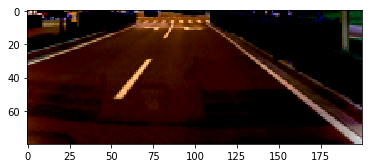

In [616]:
a,b = train_set.__getitem__(8)
x = a[0].to('cpu').detach().numpy()
k = cv2.merge([x[2,:,:],x[1,:,:],x[0,:,:]])
plt.imshow(k)

In [483]:
type(b)

numpy.float64

# Train
## model

In [675]:
class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.shape[0],-1).squeeze()
        return x

class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.f_camera_model = nn.Sequential(
                        nn.Conv2d(3,24,5,stride = 2),
                        nn.ReLU(),
                        nn.Conv2d(24,36,5,stride = 2),
                        nn.ReLU(),
                        nn.Conv2d(36,48,3,stride = 2),
                        nn.ReLU(),
                        nn.Conv2d(48,64,3,stride = 1),
                        nn.ReLU(),
                        Flatten()
                        )
        self.l_camera_model = nn.Sequential(
                        nn.Conv2d(3,24,5,stride = 2),
                        nn.ReLU(),
                        nn.Conv2d(24,36,5,stride = 2),
                        nn.ReLU(),
                        nn.Conv2d(36,48,3,stride = 2),
                        nn.ReLU(),
                        nn.Conv2d(48,64,3,stride = 1),
                        nn.ReLU(),
                        Flatten()
                        )
        self.r_camera_model = nn.Sequential(
                        nn.Conv2d(3,24,5,stride = 2),
                        nn.ReLU(),
                        nn.Conv2d(24,36,5,stride = 2),
                        nn.ReLU(),
                        nn.Conv2d(36,48,3,stride = 2),
                        nn.ReLU(),
                        nn.Conv2d(48,64,3,stride = 1),
                        nn.ReLU(),
                        Flatten()
                        )
        self.un_map_model = nn.Sequential(
                        nn.Conv2d(3,24,5,stride = 2),
                        nn.ReLU(),
                        nn.Conv2d(24,36,5,stride = 2),
                        nn.ReLU(),        
                        nn.Conv2d(36,48,3,stride = 2),
                        nn.ReLU(),
                        Flatten()
                        )
        self.ro_map_model = nn.Sequential(
                        nn.Conv2d(3,24,5,stride = 2),
                        nn.ReLU(),
                        nn.Conv2d(24,36,5,stride = 2),
                        nn.ReLU(),
                        Flatten()
                        )
        self.fc1 = nn.Linear(24960, 1000)
        self.fc2 = nn.Linear(1000,100)
        self.gmm_fc = nn.Linear(100,9)
        self.fc3 = nn.Linear(3700, 100)
        self.fc_pred = nn.Linear(100,1)
        self.relu = nn.ELU()
        
    def forward(self, fc, lc, rc, um, rm):
        out = torch.cat((self.f_camera_model(fc), 
                          self.l_camera_model(lc), 
                          self.r_camera_model(rc),
                          self.un_map_model(um)
                         ), 1)
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out)) 
        gmm_out = self.gmm_fc(out)
#         print(gmm_out.size())
        gmm_out = torch.cat((F.softmax(gmm_out[:,0:3], dim = 1), self.relu(gmm_out[:,3:9])), 1)
        out = torch.cat((out,self.ro_map_model(rm)), 1)
        out = self.relu(self.fc3(out))
        out = self.relu(self.fc_pred(out))
        out = out.view(-1)
        return gmm_out.double(), out.double()
    
class gmm_loss(nn.Module):
    def __init__(self, c, c0):
        super (gmm_loss, self).__init__()
        self.c = c
        self.c0 = c0

    def forward(self, y_gmm, y_pred, y):

        y_true = y.view(y.shape[0],1) * torch.ones((y.shape[0],3), dtype = torch.double)
        phi, mu, sigma = y_gmm[:,0:3].double(), y_gmm[:,3:6].double(), y_gmm[:,6:9].double()
        sigma = torch.ones(sigma.shape, dtype = torch.float64)
        dist = Normal(mu, self.c0*sigma)
        fs = torch.sum(phi.mul(dist.log_prob(y_true).exp()), 1)
        loss = -torch.sum(y.mul(torch.log(abs(fs)))) + F.mse_loss(y_pred, y) + torch.norm(phi, p = 2) + torch.norm(torch.log(abs(sigma)) - self.c, p = 2) 
        return abs(loss)

In [676]:
model = net()
criterion = gmm_loss(c=0.05,c0=0.5)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
#model.load_state_dict(torch.load('./model/ete_model.pth'))

In [677]:
model.to(device) 
n_epochs = 3
# score = [0] * (n_epochs + 1)
llloss = [0] * (n_epochs + 1)
mseloss = [0] * (n_epochs + 1)

for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)

    train_loss = []
    valid_loss = []
    exp_lr_scheduler.step()
    train_mse = []
    predictions = []
    gmm_pos = []
    labels = []
    # train
    toatl_batch = len(train_set)//32
    for batch_i, (data, target) in c(train_loader):
        fc, lc, rc, um, rm, target = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device), data[4].to(device), target.to(device) 
        optimizer.zero_grad()
        output = model(fc, lc, rc, um, rm)
        predictions.append(output[1].detach().numpy())
        gmm_pos.append(output[0].detach().numpy())
        labels.append(target.detach().numpy())
        loss = criterion(output[0], output[1], target)
        train_loss.append(loss.item())
        mse = F.mse_loss(output[1], target)
        train_mse.append(mse.item())
        print(f'{batch_i}/{toatl_batch} total loss: {loss}, mse: {mse}')
        loss.backward()
        optimizer.step()

#         break
        
#     break    
    llloss[epoch] = np.mean(train_loss)
    mseloss[epoch] = np.mean(train_mse)
#     acc[epoch] = sum(correct)/sum(total)
    print(f'Epoch {epoch}, gmm_loss: {llloss[epoch]}, mse_loss: {mseloss[epoch]}')
    
# acc_base_train = acc
loss_base_train = llloss

Mon Jul 29 13:25:38 2019 Epoch: 1
0/30 total loss: 3.7468160945177016, mse: 0.008885522013781837
1/30 total loss: 3.744851514820889, mse: 0.02654043593838321
2/30 total loss: 3.6420712202060423, mse: 0.010637325649751932
3/30 total loss: 3.8172113328884834, mse: 0.0008891958530937264
4/30 total loss: 3.858328163615766, mse: 0.012695281410782027
5/30 total loss: 3.8453982733666856, mse: 0.012115598245077882
6/30 total loss: 3.928107525033161, mse: 0.007319625279660983
7/30 total loss: 3.6362541425336286, mse: 0.0014958573315242256
8/30 total loss: 3.6035101985630744, mse: 0.002390940542534026
9/30 total loss: 3.7378505407191005, mse: 0.00486933085596495
10/30 total loss: 3.8144850480451913, mse: 0.008782166895730165
11/30 total loss: 3.616572041653896, mse: 0.005768575452541921
12/30 total loss: 3.9446974766057386, mse: 0.004243144590358863
13/30 total loss: 3.5872602827307576, mse: 0.002207169063797576
14/30 total loss: 3.7835914017930246, mse: 0.0018251258637731979
15/30 total loss: 3

In [630]:
mseloss

[0, 0.011359511719095848, 0.006750326816429257, 0.004584675294719912]

In [210]:
A = torch.Tensor([[1,2]])
B = torch.ones(2,3)
C = torch.randint(10,(32,9))

In [678]:
output

(tensor([[ 3.4529e-01,  3.1196e-01,  3.4275e-01,  2.1643e+00,  1.5801e+00,
           1.3382e+00,  4.7442e-01,  3.2025e-01,  3.6836e-01],
         [ 3.4525e-01,  3.2390e-01,  3.3085e-01,  1.8466e+00,  1.2933e+00,
           1.1444e+00,  4.0856e-01,  2.6196e-01,  3.0557e-01],
         [ 3.4380e-01,  3.2261e-01,  3.3359e-01,  2.1077e+00,  1.5311e+00,
           1.4730e+00,  4.7872e-01,  2.8940e-01,  3.6035e-01],
         [ 3.4033e-01,  3.2363e-01,  3.3605e-01,  2.3278e+00,  1.7388e+00,
           1.7004e+00,  5.4203e-01,  3.3151e-01,  4.1842e-01],
         [ 3.3944e-01,  3.2888e-01,  3.3168e-01,  2.7500e+00,  2.0108e+00,
           1.9298e+00,  5.9587e-01,  4.1790e-01,  4.6406e-01],
         [ 3.2429e-01,  3.4137e-01,  3.3434e-01,  2.0047e+00,  1.3984e+00,
           1.4557e+00,  4.6826e-01,  2.6412e-01,  3.4863e-01],
         [ 3.3905e-01,  3.2837e-01,  3.3258e-01,  1.9252e+00,  1.4193e+00,
           1.2030e+00,  4.2501e-01,  2.7691e-01,  3.3375e-01],
         [ 3.3347e-01,  3.3143e-01

In [679]:
output[1]

tensor([ 0.0072,  0.0184,  0.0131,  0.0014, -0.0201,  0.0499,  0.0092,  0.0013,
        -0.0055, -0.0117], dtype=torch.float64, grad_fn=<CopyBackwards>)

In [680]:
target

tensor([ 0.0031,  0.0016,  0.0048,  0.0067,  0.0015,  0.0407,  0.0094,  0.0032,
        -0.0007, -0.0003], dtype=torch.float64)

In [682]:
import math
def plot_carv(y_true, y_pred, y_gmm):
    loc = np.argmax(y_gmm[:, 0:3], axis=1)
    mean = y_gmm[:,3:6][loc]
    plt.figure(figsize=(20,10))
    plt.ylim(-0.3,0.3)
    plt.plot(y_true,'g-')
    plt.plot(y_pred, 'r-')
#     plt.plot(mean, 'y-')
    plt.legend(labels = ['real','prediction','probability'])
    plt.show()

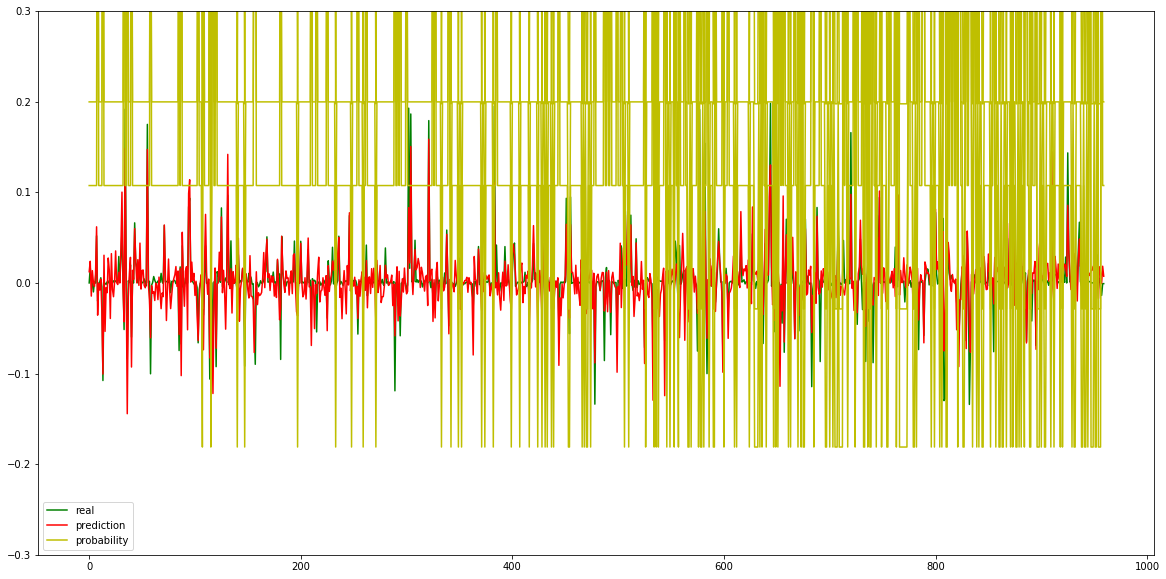

In [681]:
labels.pop()
gmm_pos.pop()
predictions.pop()
labels = np.array(labels).reshape(-1)
gmm_pos = np.array(gmm_pos).reshape(-1,9)
predictions = np.array(predictions).reshape(-1)
plot_carv(labels, predictions, gmm_pos)

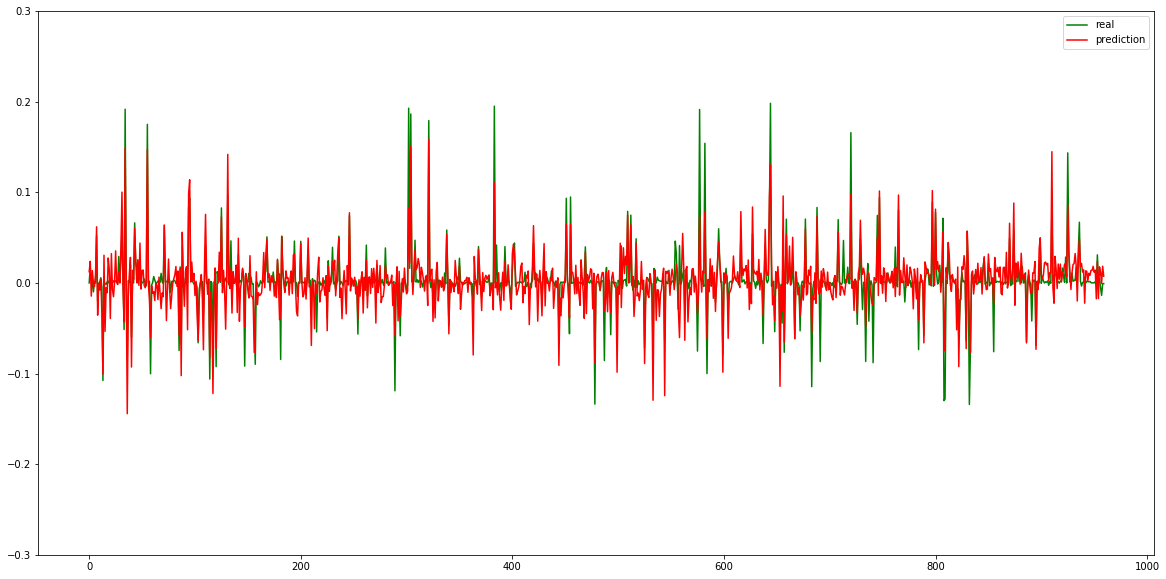

In [683]:
plot_carv(labels, predictions, gmm_pos)

In [713]:
gmm_pos

array([[ 3.13616931e-01,  3.06469262e-01,  3.79913777e-01, ...,
         7.19029009e-02, -2.58005280e-02,  4.62573487e-04],
       [ 3.14690977e-01,  3.27230692e-01,  3.58078301e-01, ...,
         2.75944471e-01,  8.58819261e-02,  1.66568756e-01],
       [ 3.22310507e-01,  3.03162426e-01,  3.74527037e-01, ...,
         1.59828812e-01,  5.36606088e-02,  5.38215674e-02],
       ...,
       [ 3.30076456e-01,  3.40617418e-01,  3.29306185e-01, ...,
         7.33811259e-01,  5.05677342e-01,  5.66284835e-01],
       [ 3.40858519e-01,  3.17179352e-01,  3.41962159e-01, ...,
         2.91645586e-01,  1.91803008e-01,  2.23019928e-01],
       [ 3.34354579e-01,  3.21278930e-01,  3.44366521e-01, ...,
         2.58503944e-01,  1.30153924e-01,  1.80271924e-01]])

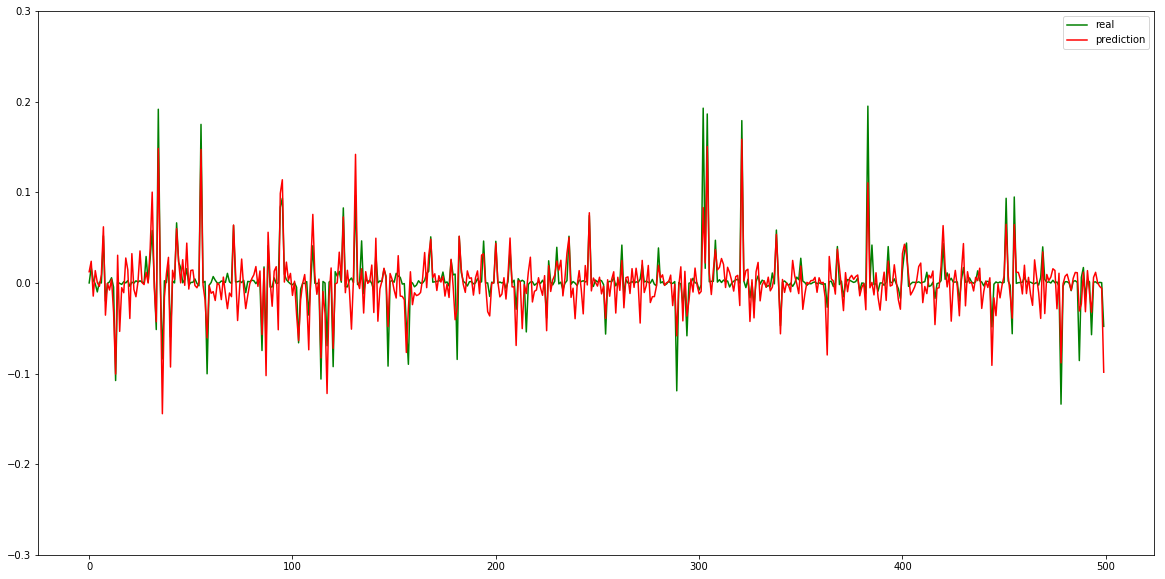

In [685]:
plot_carv(labels[0:500], predictions[0:500], gmm_pos[0:500])

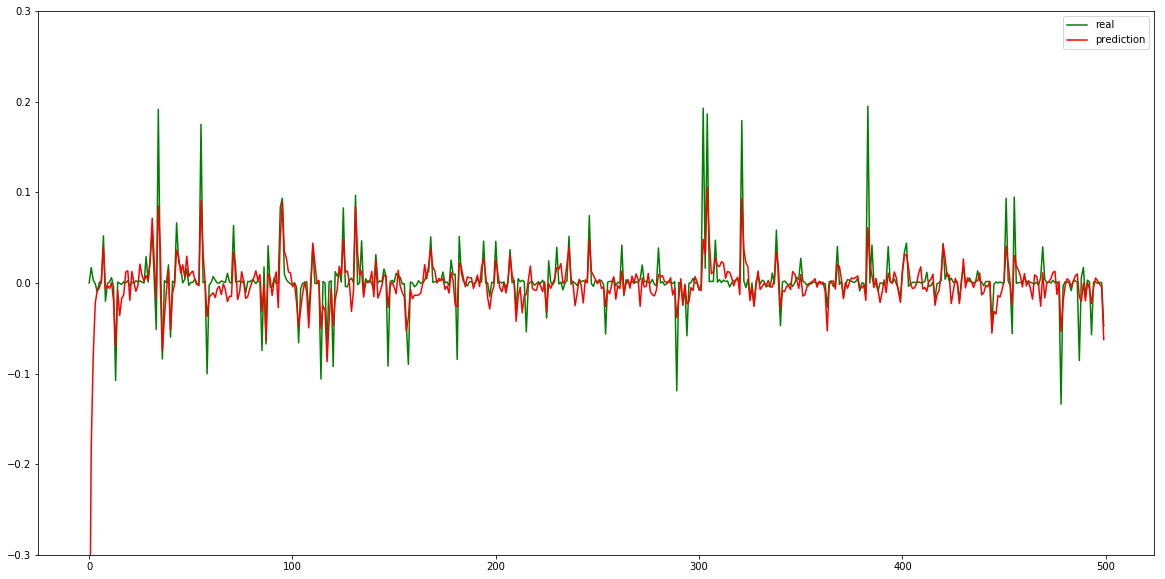

In [693]:
plot_carv(labels[0:500], mean, gmm_pos[0:500])

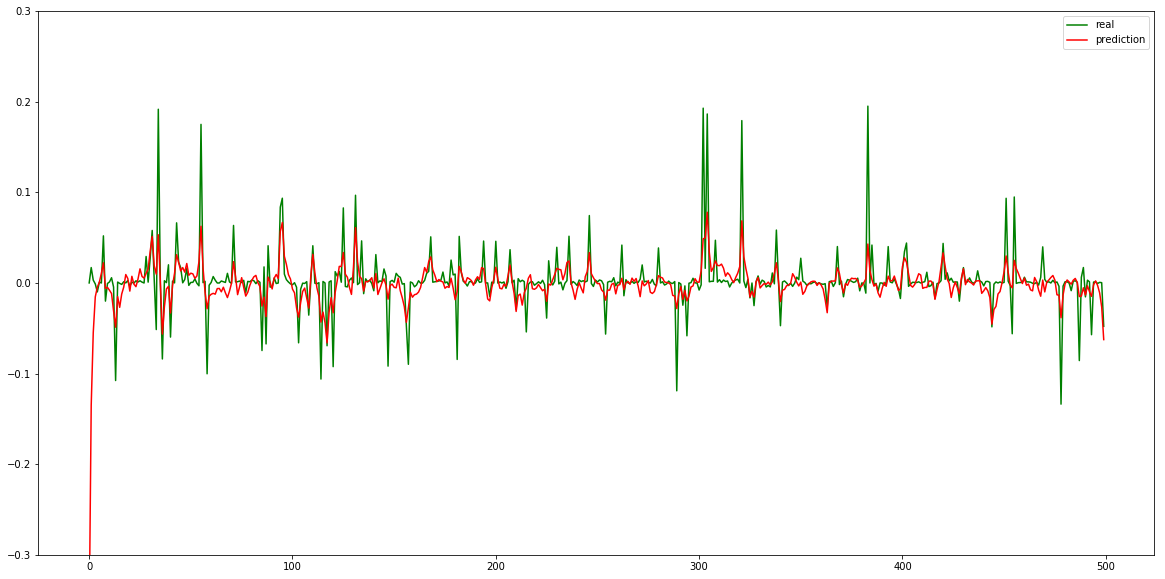

In [694]:
plot_carv(labels[0:500], mean_sm, gmm_pos[0:500])

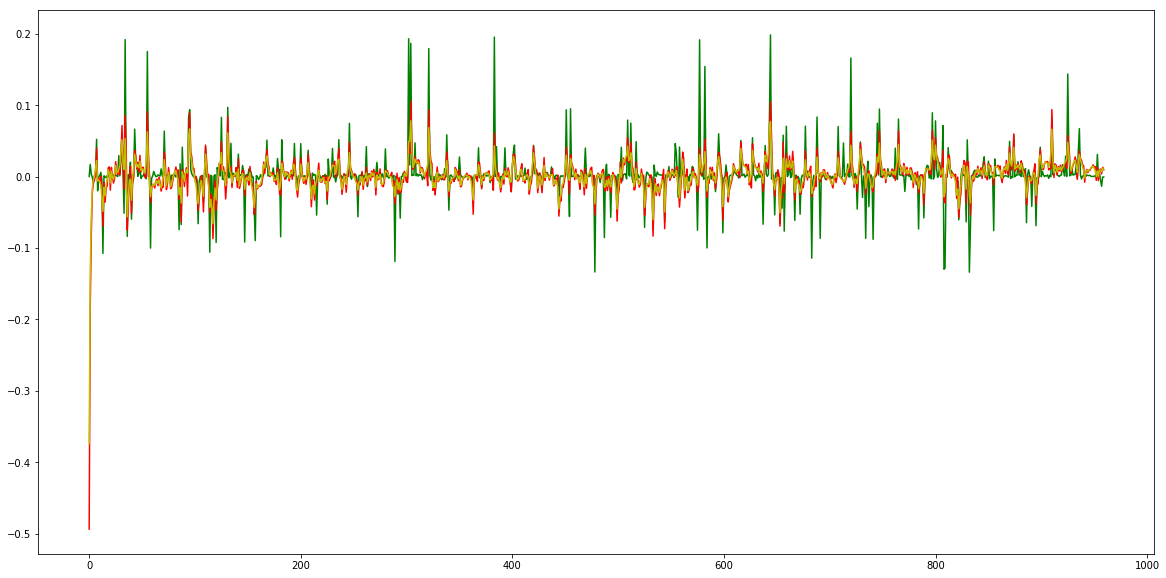

In [705]:
from pykalman import KalmanFilter
kf = KalmanFilter(n_dim_obs = 1,
                  n_dim_state = 1,
                  initial_state_mean = -1,
                  initial_state_covariance = 1,
                  transition_matrices = [1],
                  transition_covariance = np.eye(1),
                  transition_offsets = None,
                  observation_matrices = [1],
                  observation_covariance = 1
                 )

mean,cov = kf.filter(predictions)
mean_sm,cov_sm = kf.smooth(predictions)
plt.figure(figsize=(20,10))
plt.plot(labels,'g-')
plt.plot(mean, 'r-')
plt.plot(mean_sm, 'y-')
plt.show()

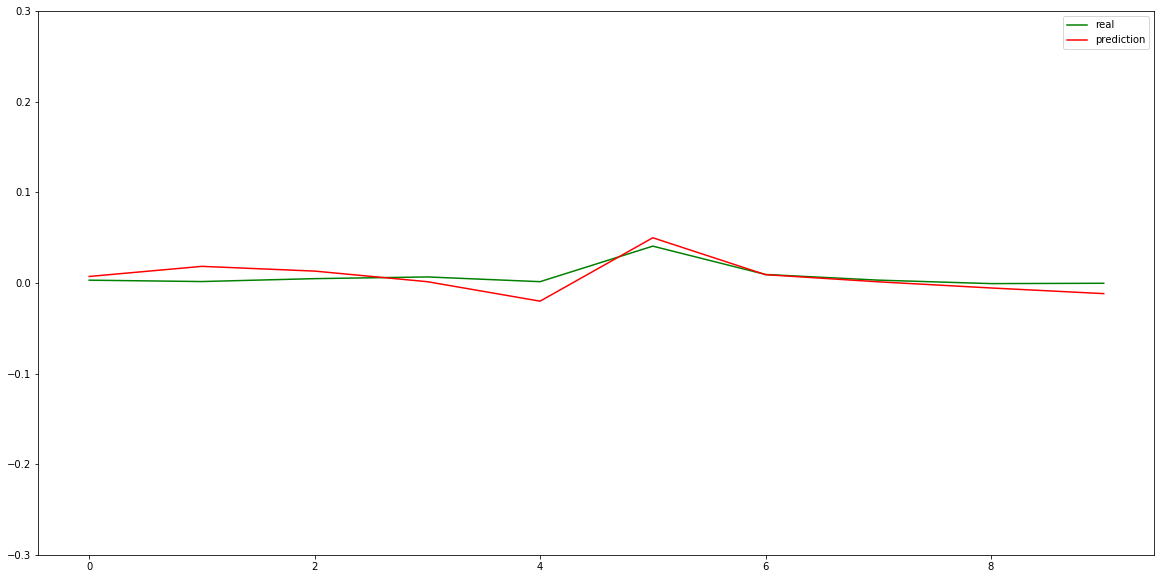

In [684]:
plot_carv(target.detach().numpy(), output[1].detach().numpy(),output[0].detach().numpy())

In [712]:
result = np.concatenate([labels.reshape(-1,1), predictions.reshape(-1,1),mean.reshape(-1,1),mean_sm.reshape(-1,1)],1)
pred = pd.DataFrame(result)
pred.columns = ['groundtruth', 'prediction', 'pred_kf', 'pred_kf_sm']
pred.to_csv('./predictions.csv')
pred.head()

,groundtruth,prediction,pred_kf,pred_kf_sm
0,0.000069,0.012440,-0.493780,-0.374206
1,0.017033,0.023983,-0.183122,-0.135058
2,0.003188,-0.014461,-0.079331,-0.054950
3,-0.001014,0.013661,-0.021895,-0.015330
4,-0.009843,0.000431,-0.008098,-0.004702


# Test

In [714]:
df_test = pd.read_csv('match.csv')
df_test = df_test.sort_values('time').iloc[1045:1749]
omega_test = df_test['angular_velocity'].values
v_test = df_test['speed'].values
carv_test = np.zeros(len(v_test))
for i in range(len(v_test)):
    carv_test[i] = omega_test[i]/v_test[i] if v_test[i]!=0 else 0
test_set = cam_Dataset(f_cam_folder='./old/forward_compressed/', l_cam_folder = './old/left_compressed/',r_cam_folder = './old/right_compressed/',ur_map_folder = './old/unrouted_map/',ro_map_folder = './old/routed_map/', df=df_test, cam_transform = cam_transforms, map_transform = map_transforms, y = carv_test)
num_workers = 0
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=num_workers)

In [715]:
len(test_set)

704

In [716]:
total_mse = []
predictions = []
gmm_pos = []
labels = []
total_batch = len(test_set)//32
for batch_i, (data, target) in enumerate(test_loader):
    fc, lc, rc, um, rm, target = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device), data[4].to(device), target.to(device) 
    output = model(fc, lc, rc, um, rm)
    mse = F.mse_loss(output[1], target)

    predictions.append(output[1].detach().numpy())
    gmm_pos.append(output[0].detach().numpy())
    labels.append(target.detach().numpy())
    total_mse.append(mse)
    print(f'{batch_i}/{total_batch} mse: {mse}')


mseloss = np.mean(total_mse)
print(f'prediction mse: {mseloss}')

0/22 mse: 0.00012462932494180257
1/22 mse: 0.00020617600589753132
2/22 mse: 0.0003885698391465664
3/22 mse: 0.0001248671811467138
4/22 mse: 0.00016405112218716102
5/22 mse: 0.0004260856823457998
6/22 mse: 0.00043526845364129477
7/22 mse: 0.00018393480781728853
8/22 mse: 0.0006852457112310685
9/22 mse: 0.0001716897552495762
10/22 mse: 7.540148767604647e-05
11/22 mse: 0.0001572177474173831
12/22 mse: 0.00021712881913473156
13/22 mse: 0.0003341249894337695
14/22 mse: 0.0029855504747329804
15/22 mse: 0.0002068860379906785
16/22 mse: 0.000414130461720143
17/22 mse: 0.0008734034664912408
18/22 mse: 0.00023007174773875946
19/22 mse: 0.00024276426058990905
20/22 mse: 2.3950858508178423e-05
21/22 mse: 0.00024661820407897176


AttributeError: 'torch.dtype' object has no attribute 'type'

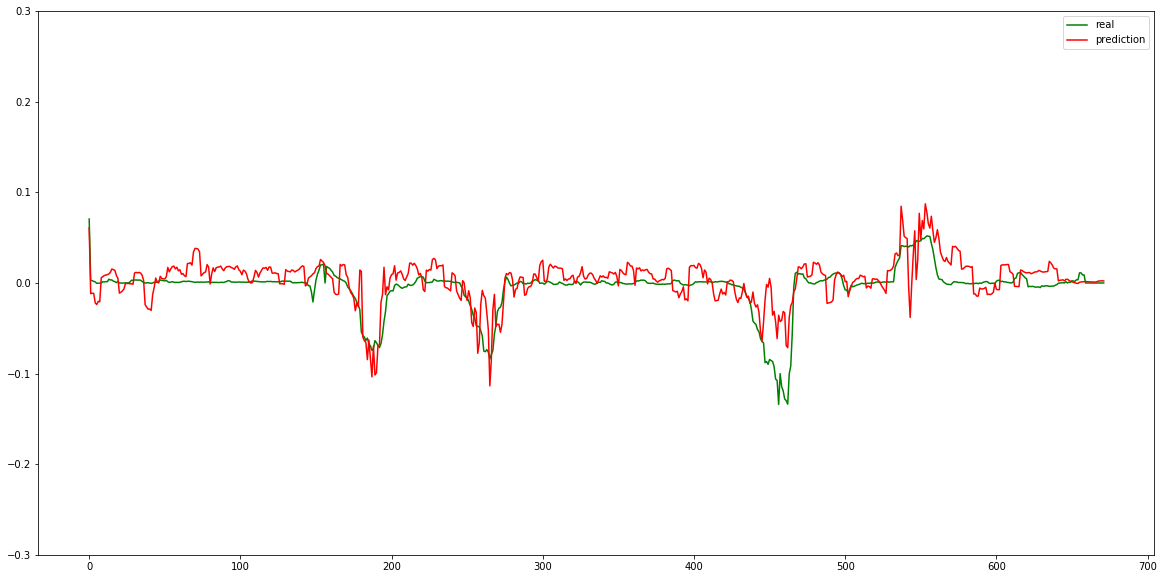

In [718]:
labels.pop()
gmm_pos.pop()
predictions.pop()
labels = np.array(labels).reshape(-1)
gmm_pos = np.array(gmm_pos).reshape(-1,9)
predictions = np.array(predictions).reshape(-1)
plot_carv(labels, predictions, gmm_pos)

23.436433732110498


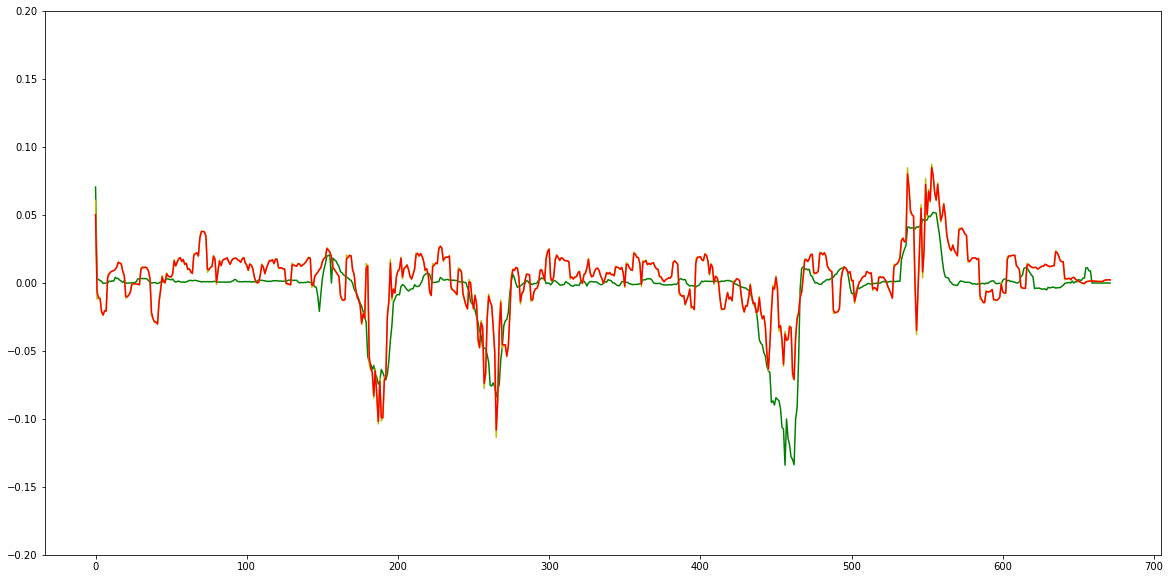

In [758]:
kf = KalmanFilter(n_dim_obs = 1,
                  n_dim_state = 1,
                  initial_state_mean = -1,
                  initial_state_covariance = 100,
                  transition_matrices = [1],
                  transition_covariance = 10*np.eye(1),
                  transition_offsets = None,
                  observation_matrices = [1],
                  observation_covariance = 1
                 )

mean,cov = kf.filter(predictions)
mean_sm,cov_sm = kf.smooth(predictions)
plt.figure(figsize=(20,10))
plt.plot(labels,'g-')
plt.plot(predictions,'y-')
plt.plot(mean, 'r-')
plt.ylim(-0.2,0.2)
print(np.linalg.norm(mean-labels))
# plt.plot(mean_sm, 'y-')
plt.show()

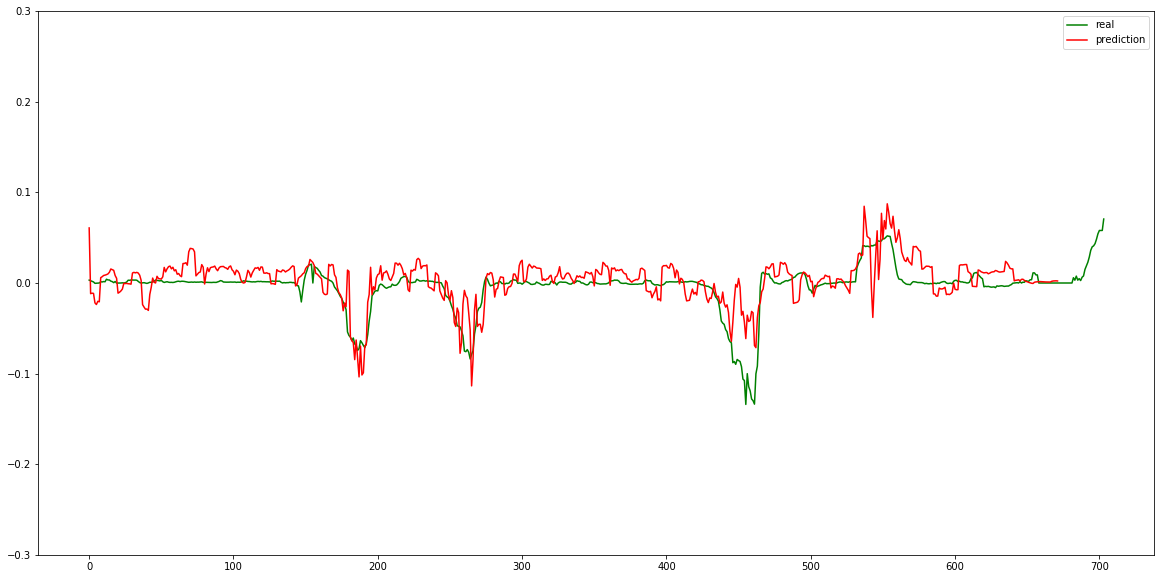

In [722]:
plot_carv(carv_test, predictions, gmm_pos)

In [726]:
result = np.concatenate([labels.reshape(-1,1), predictions.reshape(-1,1)],1)
pred = pd.DataFrame(result)
pred.columns = ['groundtruth', 'prediction']
pred.to_csv('./sorted_predictions_1045-1749.csv')
pred.head()

,groundtruth,prediction
0,0.070598,0.060768
1,0.003188,-0.011768
2,0.002489,-0.011248
3,0.001901,-0.011487
4,0.001174,-0.021944


In [ ]:
model.eval()
predict = model(Variable(x_train))
predict = predict.data.numpy()